In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm

In [18]:
data_path = "/Users/vedikagoyal/Desktop/python_jn/walmart"

# Load CSV files
train_df = pd.read_csv(os.path.join(data_path, "train.csv"), parse_dates=['Date'])
features_df = pd.read_csv(os.path.join(data_path, "features.csv"), parse_dates=['Date'])
stores_df = pd.read_csv(os.path.join(data_path, "stores.csv"))

# Merge datasets
df = train_df.merge(stores_df, on='Store', how='left')
df = df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

print("Merged dataset shape:", df.shape)
print(df.head())

Merged dataset shape: (421570, 16)
   Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1 2010-02-05      24924.50      False    A  151315        42.31   
1      1     1 2010-02-12      46039.49       True    A  151315        38.51   
2      1     1 2010-02-19      41595.55      False    A  151315        39.93   
3      1     1 2010-02-26      19403.54      False    A  151315        46.63   
4      1     1 2010-03-05      21827.90      False    A  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  
0  211.096358        

In [19]:
# Feature Engineering
# Sort by date
df = df.sort_values("Date")

# Time features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week
df["DayOfWeek"] = df["Date"].dt.dayofweek

# Lag features (store-level)
df["Lag_1"] = df.groupby("Store")["Weekly_Sales"].shift(1)
df["Lag_2"] = df.groupby("Store")["Weekly_Sales"].shift(2)

# Rolling averages (store-level)
df["Rolling_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(4).mean()
df["Rolling_12"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(12).mean()

# Drop missing values from lags/rolling
df = df.dropna()

print("Features created:", df.columns)

Features created: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month',
       'Week', 'DayOfWeek', 'Lag_1', 'Lag_2', 'Rolling_4', 'Rolling_12'],
      dtype='object')


In [20]:
# Train-Test Split (Time-aware)
features = ["Store", "Dept", "Size", "Temperature", "Fuel_Price", "CPI", "Unemployment",
            "IsHoliday", "Year", "Month", "Week", "DayOfWeek", 
            "Lag_1", "Lag_2", "Rolling_4", "Rolling_12"]

X = df[features]
y = df["Weekly_Sales"]

# 80% train, 20% test
split_point = int(len(df) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
dates_test = df["Date"].iloc[split_point:]

In [28]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\n Linear Regression:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²:", r2_score(y_test, y_pred_lr))


 Linear Regression:
RMSE: 22091.078013350998
R²: 0.09903944608432613


In [29]:
# Model 2: XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))


XGBoost:
RMSE: 6518.008724036901
R²: 0.9215664570481018


In [30]:
# Model 3: LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("\n LightGBM:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("R²:", r2_score(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2117
[LightGBM] [Info] Number of data points in the train set: 77644, number of used features: 15
[LightGBM] [Info] Start training from score 17960.688598

 LightGBM:
RMSE: 6733.598638348957
R²: 0.9162921069022711


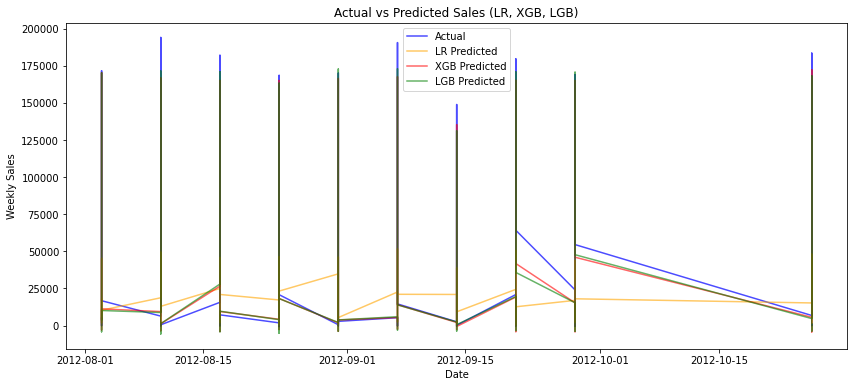

In [24]:
#  Plot Actual vs Predicted (Comparison)
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(dates_test, y_pred_lr, label="LR Predicted", color="orange", alpha=0.6)
plt.plot(dates_test, y_pred_xgb, label="XGB Predicted", color="red", alpha=0.6)
plt.plot(dates_test, y_pred_lgb, label="LGB Predicted", color="green", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Sales (LR, XGB, LGB)")
plt.legend()
plt.show()

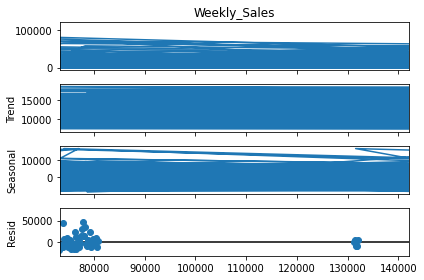

In [25]:
# Bonus: Seasonal Decomposition
decomposition = sm.tsa.seasonal_decompose(df["Weekly_Sales"].iloc[:500], model='additive', period=52)
decomposition.plot()
plt.show()

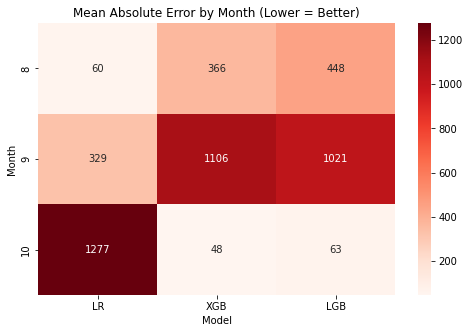

In [26]:
# Error Heatmap by Month
pred_df = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test.values,
    "LR_Pred": y_pred_lr,
    "XGB_Pred": y_pred_xgb,
    "LGB_Pred": y_pred_lgb
})

# Extract month
pred_df["Month"] = pred_df["Date"].dt.month

# Calculate errors
pred_df["LR_Error"] = pred_df["Actual"] - pred_df["LR_Pred"]
pred_df["XGB_Error"] = pred_df["Actual"] - pred_df["XGB_Pred"]
pred_df["LGB_Error"] = pred_df["Actual"] - pred_df["LGB_Pred"]

# Group by month and calculate mean absolute error
error_monthly = pred_df.groupby("Month")[["LR_Error", "XGB_Error", "LGB_Error"]].mean().abs()

# Rename columns for heatmap
error_monthly.columns = ["LR", "XGB", "LGB"]

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(error_monthly, annot=True, cmap="Reds", fmt=".0f")
plt.title("Mean Absolute Error by Month (Lower = Better)")
plt.ylabel("Month")
plt.xlabel("Model")
plt.show()



 Accuracy Report
               Model          RMSE           MAE  R2 Score
0  Linear Regression  22091.078013  15270.107852  0.099039
1            XGBoost   6518.008724   3854.715089  0.921566
2           LightGBM   6733.598638   4005.898108  0.916292


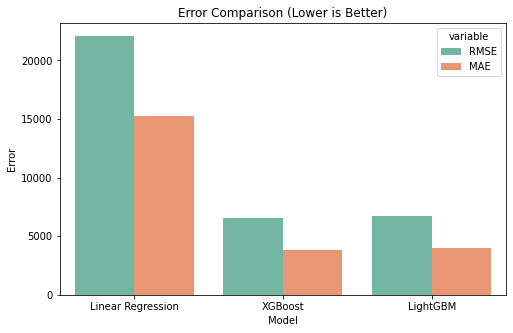

In [27]:
from sklearn.metrics import mean_absolute_error

# Calculate metrics for all models
metrics = {
    "Model": ["Linear Regression", "XGBoost", "LightGBM"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_pred_lgb))
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_lgb)
    ],
    "R2 Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_lgb)
    ]
}

accuracy_report = pd.DataFrame(metrics)

# Print Accuracy Report
print("\n Accuracy Report")
print(accuracy_report)

# Plot Accuracy Comparison
plt.figure(figsize=(8,5))
sns.barplot(data=accuracy_report.melt(id_vars="Model", value_vars=["RMSE","MAE"]), 
            x="Model", y="value", hue="variable", palette="Set2")
plt.title("Error Comparison (Lower is Better)")
plt.ylabel("Error")
plt.show()


In [32]:
# Pick the Best Model (XGBoost vs LightGBM)
best_model = xgb_model if r2_score(y_test, y_pred_xgb) > r2_score(y_test, y_pred_lgb) else lgb_model
best_model_name = "XGBoost" if best_model == xgb_model else "LightGBM"

print(f"\nUsing {best_model_name} for future forecasting.")

#Create Future Dates (Next 8 Weeks)
last_date = df["Date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=8, freq='W')

future_df = pd.DataFrame({"Date": future_dates})

# Prepare Features for Future Data
latest_data = df.groupby("Store").tail(12)  # last 12 weeks per store

future_features = []

for store in df["Store"].unique():
    store_data = latest_data[latest_data["Store"] == store].copy()

    for week_date in future_dates:
        # Time features
        year = week_date.year
        month = week_date.month
        week = week_date.isocalendar()[1]
        dow = week_date.dayofweek

        # Lag & rolling features
        lag_1 = store_data["Weekly_Sales"].iloc[-1]
        lag_2 = store_data["Weekly_Sales"].iloc[-2]
        roll_4 = store_data["Weekly_Sales"].iloc[-4:].mean()
        roll_12 = store_data["Weekly_Sales"].iloc[-12:].mean()

        # Collect features
        future_features.append([
            store, store_data["Dept"].iloc[-1], store_data["Size"].iloc[-1],
            store_data["Temperature"].iloc[-1], store_data["Fuel_Price"].iloc[-1],
            store_data["CPI"].iloc[-1], store_data["Unemployment"].iloc[-1],
            store_data["IsHoliday"].iloc[-1], year, month, week, dow,
            lag_1, lag_2, roll_4, roll_12
        ])

        # Predict sales & append to store_data to update lag
        pred_input = np.array(future_features[-1]).reshape(1, -1)
        pred_sales = best_model.predict(pred_input)[0]
        store_data = pd.concat([store_data, pd.DataFrame({"Weekly_Sales": [pred_sales]})], ignore_index=True)


Using XGBoost for future forecasting.



Future 8 Weeks Sales Forecast:
        Date  Predicted_Sales
0 2012-11-04     12237.982422
1 2012-11-11     -3436.176758
2 2012-11-18     -3404.212402
3 2012-11-25     -2022.937622
4 2012-12-02     -2469.889404
5 2012-12-09     -1159.822754
6 2012-12-16       -15.801910
7 2012-12-23      3412.386475


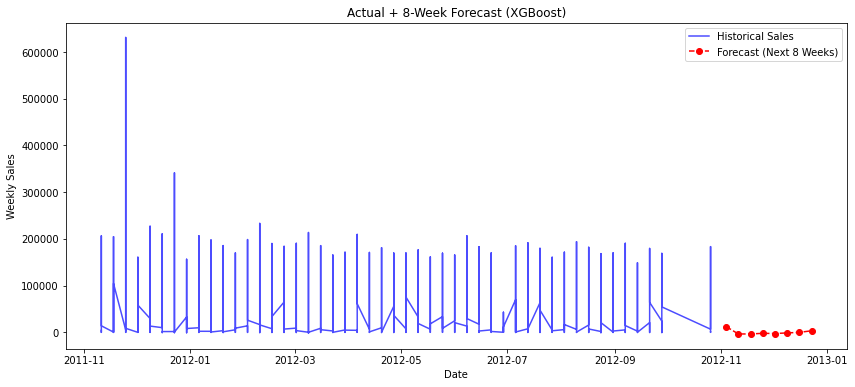

In [35]:
# Convert to DataFrame
future_X = pd.DataFrame(future_features, columns=features)
#Predict Future Sales
future_X["IsHoliday"] = future_X["IsHoliday"].fillna(0).astype(int)
future_preds = best_model.predict(future_X)

future_df["Predicted_Sales"] = future_preds[:len(future_dates)]
print("\nFuture 8 Weeks Sales Forecast:")
print(future_df)
# Plot Actual + Forecast
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Weekly_Sales"], label="Historical Sales", color="blue", alpha=0.7)
plt.plot(future_df["Date"], future_df["Predicted_Sales"], label="Forecast (Next 8 Weeks)", 
         color="red", linestyle="--", marker="o")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title(f"Actual + 8-Week Forecast ({best_model_name})")
plt.legend()
plt.show()
